# Adaptive Intelligence COM3240 Assignment A

## Competitive Learning on the reduced MNIST database

### Context

A reduced data set derived from the MNIST database http://yann.lecun.com/exdb/mnist/ is provided in csv format. This is also accompanied by a set of labels for the data, purely for guidance purposes.

In [7]:
###
### Imports, Setup, + helper function
###

import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy.ndimage
from sklearn import preprocessing
%matplotlib inline

def log_progress(sequence, every=None, size=None, name='Items'):
    # Code for progress bar taken from https://github.com/alexanderkuk/log-progress
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

feature_size = 784
num_samples = 5000


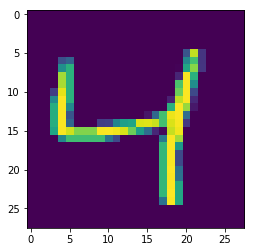

In [8]:
###
### Read in the data set
###

raw_train = np.genfromtxt ('digits/train.csv', delimiter=",")
train_labels = np.genfromtxt('digits/trainlabels.csv', delimiter=",", dtype=int)
image_shape = (28, 28)

[feature_size, num_samples] = np.shape(raw_train)  # number of pixels and number of training data
print("feature_size =", feature_size)
print("num_samples =", num_samples)

demo_image = np.reshape(raw_train[:,2], image_shape, order="F")
plt.imshow(demo_image, cmap = 'viridis')

train = preprocessing.normalize(raw_train, axis=0, norm='l1') # Normalize the data using scikit-learn

In [9]:
###
### Parameters
###

eta = 0.09; # learning rate (sometimes α, sometimes eta (η))
output_quantity = 25 # Clustering is not perfect, some numbers may have two clusters, some clusters may be 'dead'
iterations = 25000
test_runs = 50

# Optimisations
noise_max = 0.005 # 0.005
rotation_max = 5 # 5
leaky_learning_rate = 0.001 # 0.001


####  Implementation, training and output

$$ W.shape = 15x784 $$
$$ X.shape = 784x1 $$
$$ Y.shape = 15x1 $$

##### Post-synaptic Neuron Calc

$$ y_i = \sum_j w_{i, j}x_j $$
$$ \boldsymbol{y} = \boldsymbol{W}\boldsymbol{x}^{T} $$

##### Hebb Rule

$$\Delta w_{ij} = \eta x_{i} y_{j}$$
$$\Delta \boldsymbol{W} = \eta \boldsymbol{x} \boldsymbol{y}^{T}$$

##### Standard Competitive Learning Rule

$$ \Delta w_{ij} = \eta (x_j - w_{ij})$$
$$ \Delta \boldsymbol{w}_{i} = \eta (\boldsymbol{x} - w_{i})$$

##### Oja's Rule

$$ \Delta w_{ij} = \eta (x_j y_i - y_i^2 w_{ij}) $$
$$ \Delta \boldsymbol{w}_i = \eta (\boldsymbol{x}y_i - y_i^2\boldsymbol{w}_i) $$

#### Evaluation

##### Cluster Purity

https://en.wikipedia.org/wiki/Cluster_analysis

$$ Purity = \frac{1}{N} \sum_{i=1}^{k} max_j | c_i \cap t_j |$$

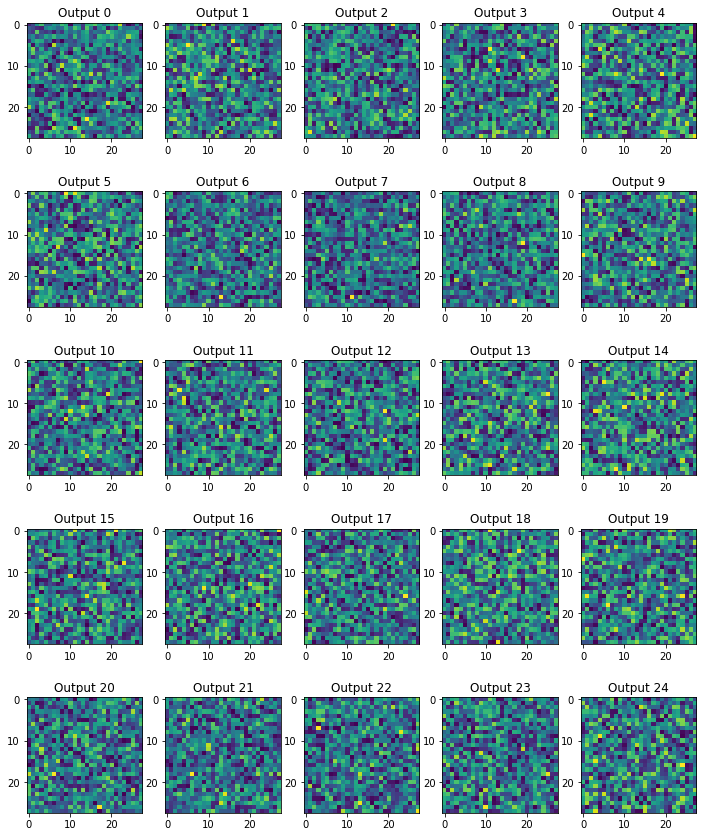

In [10]:
def reset_W():
    global W
    W = preprocessing.normalize(np.random.rand(output_quantity, feature_size), axis=0, norm='l1')

def plot_W(W):
    # Function for plotting the weight matrix for each output unit.
    
    fig = plt.figure(figsize=(12,3*(output_quantity // 5)))

    cols = 5
    rows = (W.shape[0] // cols) + (1 if W.shape[0] % cols > 0 else 0)

    for output in range(output_quantity):
        ax = fig.add_subplot(rows, cols, output + 1)
        ax.set_title('Output %d' %(output,))
        ax.imshow(W[output, :].reshape(image_shape, order='F'), interpolation='nearest', cmap='viridis');

    plt.show()

reset_W()
plot_W(W) # Plot our initial weights!

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

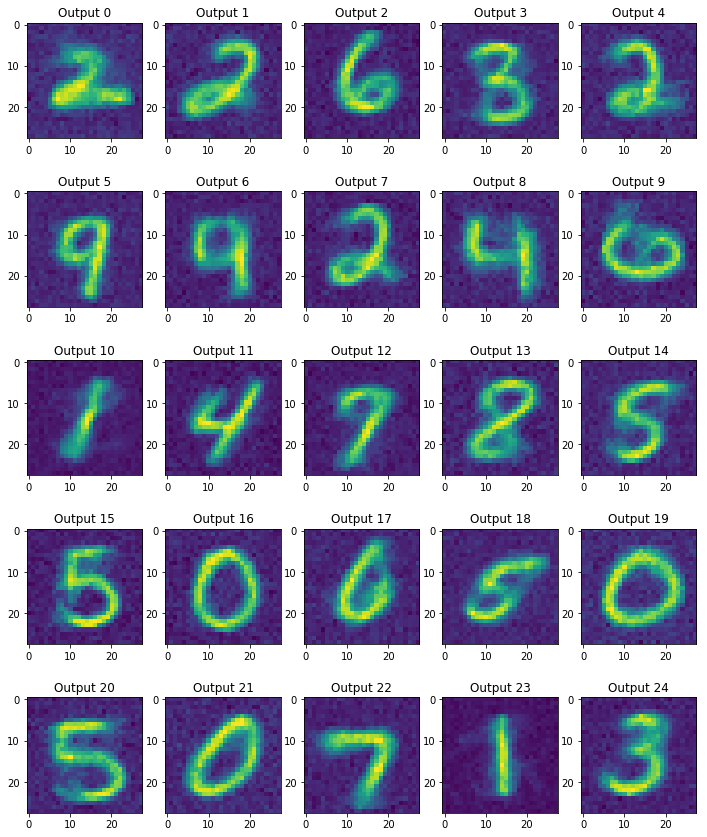

In [11]:
def simple_competitive_rule(x, y, W, max_index):
    # y is not used
    delta_W = np.ma.array(np.zeros(W.shape), mask=False)
    
    weight_change_vector = eta * (x.T - W[max_index])
    
    delta_W[max_index] = weight_change_vector
    
    delta_W.mask[max_index] = True
    delta_W += weight_change_vector * leaky_learning_rate
    
    return delta_W.data

def oja(x, y, W, max_index): 
    # Vectorized Oja's 🏎 
    # But this becomes the simple rule 
    
    # Create an empty matrix for Weight (mask for leaky learning)
    delta_W = np.ma.array(np.zeros(W.shape), mask=False)
    
    # Calculate weight change
    lhs = x * y[max_index]
    rhs = (y[max_index]**2) * W[max_index,:]
    weight_change = eta * (lhs - rhs)
    
    delta_W[max_index,:] = weight_change # Update winning weight vector
    
    if leaky_learning_rate != 0:
        delta_W.mask[max_index] = True
        delta_W += weight_change * leaky_learning_rate # Update all other weight vectors (leaky learning)
    
    return delta_W.data # Return just matrix, no mask
    
    
# Reset stats for all test runs
dead_unit_count_per_run = np.zeros(test_runs)
    
for test_run in log_progress(range(test_runs)):
    # Init W with random values between 0-1, then normalize (just in case rand didn't turn out very rand)
    reset_W()
    
    # Reset stats for each test run
    winner_count = np.zeros((output_quantity,1))
    weight_change = np.zeros((iterations))
    mean_weight_change = np.zeros((iterations))

    for t in log_progress(range(iterations)):
        i = math.ceil(num_samples * np.random.rand()) - 1 # Pick a random sample from the input
        
        input_sample = deepcopy(train[:,i])
        
        if rotation_max != 0:
            rand = np.random.rand(1,1)
            rotation_angle = (np.random.rand(1,1) * rotation_max * 2) - rotation_max
            input_sample = np.reshape(input_sample, image_shape) # Reshape to the image
            input_sample = scipy.ndimage.rotate(input_sample, rotation_angle, reshape=False) # Rotate the image
            input_sample = np.reshape(input_sample, feature_size) # Back to a flat vector
            
        if noise_max != 0:
            input_sample += np.random.rand(feature_size) * noise_max # Add noise

        x = input_sample # Presynaptic
        y = np.dot(W, x) # Postsynaptic

        max_index = np.argmax(y) # Get winner
        winner_count[max_index] += 1 # Update winner count

        d_W = simple_competitive_rule(x, y, W, max_index) # Calculate delta W

        W += d_W # Update W
        
        # Stats
        weight_change[t] = np.absolute(d_W[max_index].mean())
        if t != 0:
            mean_weight_change[t] = ((mean_weight_change[t-1]*(t-1)) + weight_change[t]) * (1/t)
        else:
            mean_weight_change[t] = weight_change[t]
            
    dead_unit_count_per_run[test_run] = np.count_nonzero(winner_count.flatten() < iterations * 0.02)
    
plot_W(W)

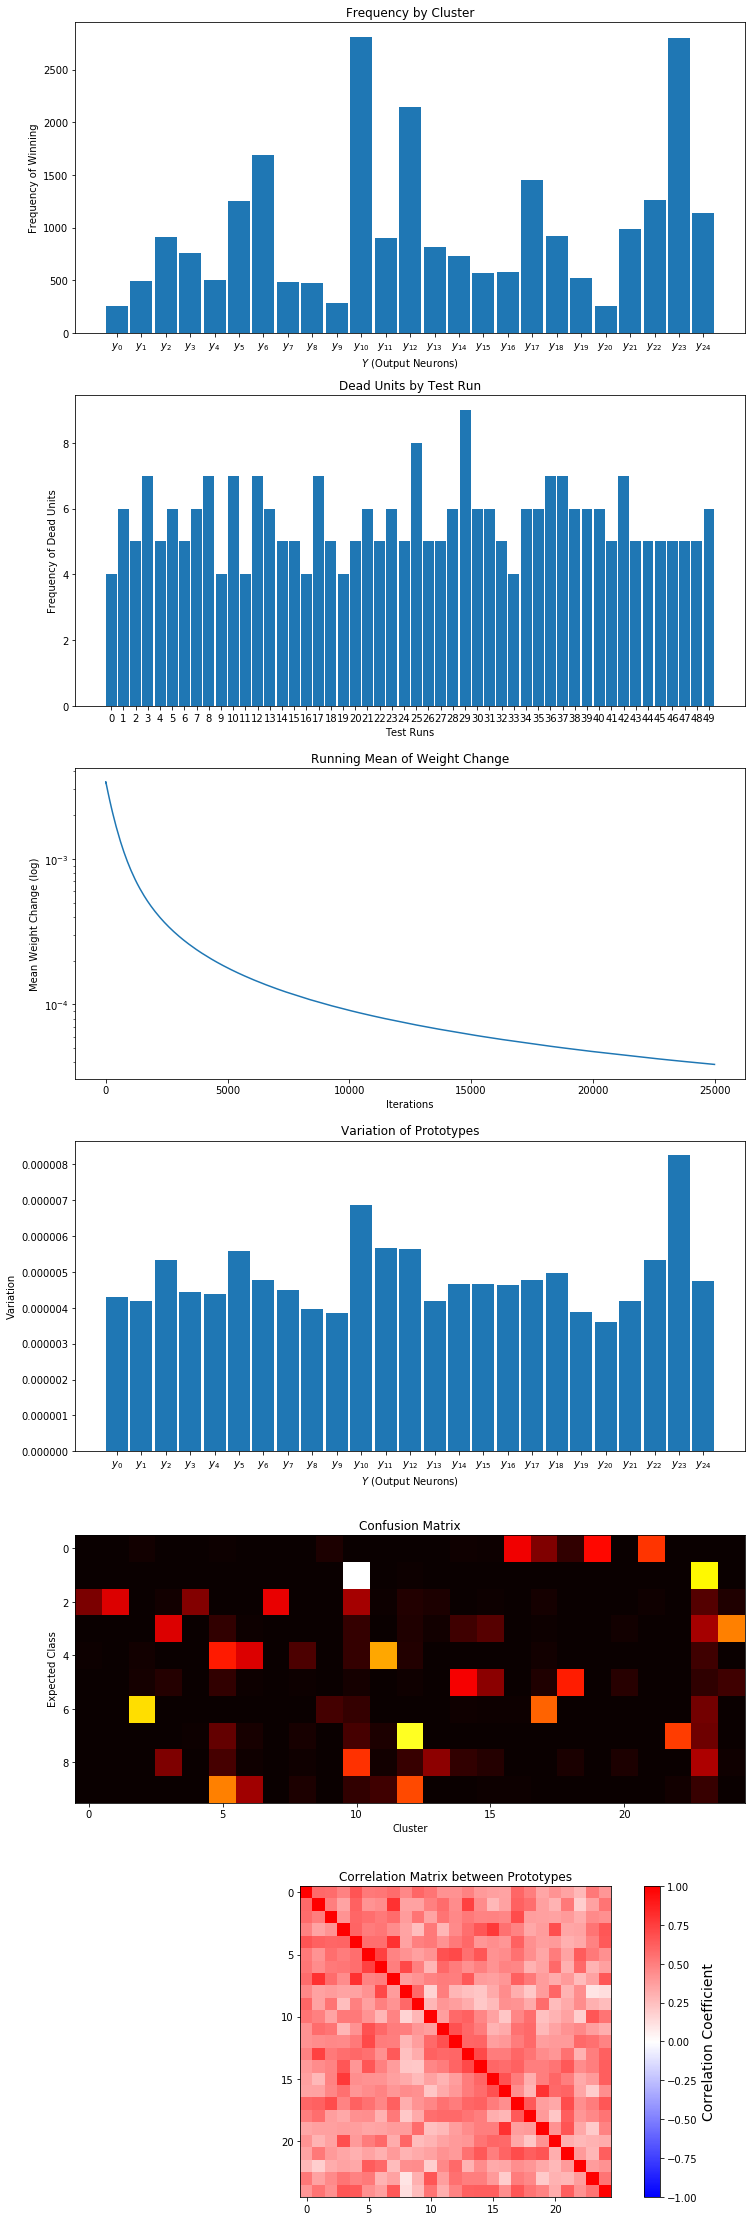

Mean Dead Units: 5.64
Cluster Purity: 0.6522


In [12]:
def get_confusion_matrix():
    confusion_m = np.zeros((10, output_quantity))
    for i in range(num_samples):
        confusion_m[train_labels[i], np.argmax(np.dot(W, train[:,i]))] += 1
    return confusion_m

def cluster_purity():
    confusion_m = get_confusion_matrix()
    return np.max(confusion_m, axis=0).sum() / num_samples

plot_count = 6
fig, ax = plt.subplots(nrows=plot_count, figsize=(12, 40))
x_positions = np.arange(output_quantity)
bar_labels = list(map(lambda x: r"$y_{%s}$" %(x), x_positions))
bar_width = 0.9

ax[0].set_title('Frequency by Cluster')
ax[0].bar(x_positions, winner_count.reshape(output_quantity),bar_width)
ax[0].set_xlabel(r"$Y$ (Output Neurons)")
ax[0].set_ylabel("Frequency of Winning")
ax[0].set_xticks(x_positions)
ax[0].set_xticklabels(bar_labels)

ax[1].set_title('Dead Units by Test Run')
ax[1].bar(np.arange(test_runs), dead_unit_count_per_run, bar_width)
ax[1].set_xlabel("Test Runs")
ax[1].set_ylabel("Frequency of Dead Units")
ax[1].set_xticks(np.arange(test_runs))
ax[1].set_xticklabels(np.arange(test_runs))

ax[2].set_title('Running Mean of Weight Change')
ax[2].plot(mean_weight_change)
ax[2].set_yscale('log')
ax[2].set_ylabel('Mean Weight Change (log)')
ax[2].set_xlabel('Iterations')

ax[3].set_title('Variation of Prototypes')
variances = np.var(W, axis=1)  
ax[3].bar(x_positions, variances, bar_width)
ax[3].set_ylabel('Variation')
ax[3].set_xlabel(r"$Y$ (Output Neurons)")
ax[3].set_xticks(x_positions)
ax[3].set_xticklabels(bar_labels)
ax[3].legend(loc='best')

im4 = ax[4].imshow(get_confusion_matrix(), cmap = 'hot')
ax[4].set_ylabel('Expected Class')
ax[4].set_xlabel('Cluster')
ax[4].set_title('Confusion Matrix')

pixels = np.reshape(np.corrcoef(W), (output_quantity,output_quantity), order="F")
im5 = ax[5].imshow(pixels, cmap = 'bwr', vmin=-1, vmax=1) # Set vmin & vmax, to illustrate range of coef
cb = plt.colorbar(im5)
cb.set_label('Correlation Coefficient',size=14)
ax[5].set_title('Correlation Matrix between Prototypes')

plt.show()

print("Mean Dead Units:", dead_unit_count_per_run.mean())
print("Cluster Purity:", cluster_purity())
